# Movie recommendation engine
Based on the processed data "imdb-5000-movie-dataset/processed_movie_metadata.csv" (see the cleaning notebook "Clean and exploration IMDB.ipynj" for more information), we will explore some models to build a movie recommendation engine.
The user will propose a movie and the recommendation engine shall return a list of 5 similar "good" movies.  
3 models have been tested:  
1. PCA
2. Kmeans  
3. NearestNeighbors.

# 0. Inputs

In [1]:
import pandas as pd

data = pd.read_csv("imdb-5000-movie-dataset/processed_movie_metadata.csv", index_col=0)
data.head(5)

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,Western,Drama,History,Sport,Crime,Horror,War,Biography,Music,director_size
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,0,0,0,0,0,0,0,0,0,0.2692
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,0,0,0,0,0,0,0,0,0,0.2692
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,0,0,0,0,0,0,0,0,0,0.2692
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,0,0,0,0,0,0,0,0,0,0.3077
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,0,0,0,0,0,0,0,0,0,0.0385


In [2]:
dummy = list(data.loc[:,"international":].columns.values)

In order to visualised futur results, we create a list of "wellknown" films called "my_selection". This list is created to countain at least 3 occurences on each of our dummy variables (top genres+keywords).

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# my selection of movies (the ones i know)
my_selection = ["Men in Black 3",
                "War of the Worlds","Star Wars: Episode I - The Phantom Menace",
                "Out of Africa","Romeo + Juliet","Love Actually",
                "Good Morning, Vietnam","Spy Game","The Hitchhiker's Guide to the Galaxy",
                "Scream 3", "Final Destination 5", "Saw II",
                "Madagascar: Escape 2 Africa", "Inside Job","Die Hard with a Vengeance",
                "Memento","Transsiberian",
                "RoboCop 3","Police Academy",
                "The Rage: Carrie 2","Twilight",
                "Antarctica: A Year on Ice","March of the Penguins",
                "The Incredibles","Monsters, Inc.",
                "The Phantom of the Opera","The Magic Flute","Snow White and the Seven Dwarfs",
                "The Legend of Zorro","The Good, the Bad, the Weird","Django Unchained",
                "Gandhi, My Father", "Alexander","Seven Years in Tibet",
                "Love & Basketball","Shaolin Soccer","Rocky Balboa"
               ]

mask_my_selection = data["movie_title"].isin(my_selection)

x = data.loc[mask_my_selection, dummy].sum()
info = {"title": "tags for my selection of movies", "xlab": "count", "ylab":"Variables"}

# plot
plt.figure(figsize=(6,10))
plt.title(info["title"], fontweight="bold", size = 20)
plt.xlabel(info["xlab"])
sns.barplot(x= x.values, y= x.index, label="Total", color="g");

# 1. PCA
PCA is a common approach to reduce tdata set dimentions. more information [here](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).

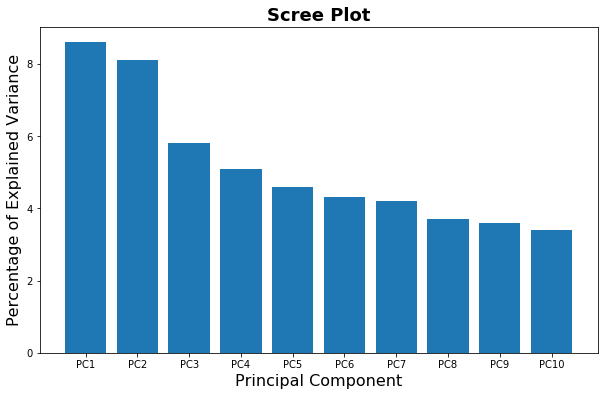

In [4]:
# Perform PCA
from sklearn.decomposition import PCA
from sklearn import preprocessing
import numpy as np

# scale inputs
dum_var = preprocessing.scale(data[dummy])

# model
pca = PCA() # create a PCA object
pca.fit(dum_var) # do the math
pca_data = pca.transform(dum_var) # get PCA coordinates for scaled_data (return nparray)

# Draw a scree plot and a PCA plot
per_var = np.round(pca.explained_variance_ratio_[:10]* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
 
plt.figure(figsize=(10,6))
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance', size = 16)
plt.xlabel('Principal Component', size = 16)
plt.title("Scree Plot", size = 18, fontweight="bold")
plt.show()

In [5]:
pca.explained_variance_ratio_[:10]

array([0.08635167, 0.08128545, 0.05754497, 0.05051372, 0.04633492,
       0.04329168, 0.04163409, 0.03746046, 0.03601929, 0.0342633 ])

The two first composents only explain 16% of the variability. This is too low to be used. we will still draw some graphs for information.  
PCA does not seems very relevant for building the recommendation engine.

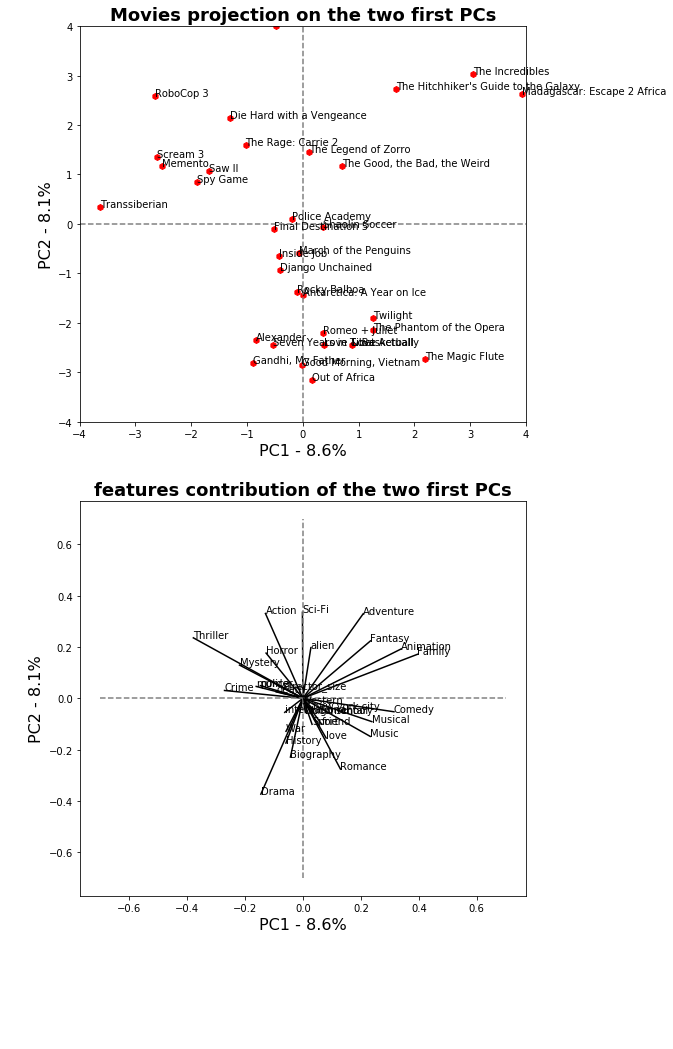

In [6]:
# movies selection in 2D (PC1-PC2)

per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

# inputs plot1
pca_df = pd.DataFrame(pca_data,index=  data["movie_title"], columns=labels) #, , index=  data["movie_title"]
mask_my_selection.index = data["movie_title"]
pca_df = pca_df[mask_my_selection]

# inputs plot 2
pcs = pca.components_


#plot 1 
plt.figure(figsize=(8,16))
plt.subplot(2,1,1)
plt.scatter(pca_df.PC1, pca_df.PC2, marker = "h", c = "red")
plt.title("Movies projection on the two first PCs", size = 18, fontweight="bold")
plt.xlabel('PC1 - {0}%'.format(per_var[0]), size = 16)
plt.ylabel('PC2 - {0}%'.format(per_var[1]), size = 16)
plt.xlim([-4,4])
plt.ylim([-4,4])
 
for sample in pca_df.index:
    plt.annotate(sample, (pca_df.PC1.loc[sample], pca_df.PC2.loc[sample]), size = 10)
 
# Afficher les lignes horizontale y=0 et verticale x=0
plt.plot([-4,4], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-4,4], color='grey', ls='--')

# plot 2

plt.subplot(2,1,2)
for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):
    # Afficher un segment de l'origine au point (x, y)
    plt.plot([0, x], [0, y], color='k')
    # Afficher le nom (data.columns[i]) de la performance
    plt.text(x, y, dummy[i] , fontsize='10')
    plt.title("features contribution of the two first PCs", size = 18, fontweight="bold")

plt.xlabel('PC1 - {0}%'.format(per_var[0]), size = 16)
plt.ylabel('PC2 - {0}%'.format(per_var[1]), size = 16)
# Afficher les lignes horizontale y=0 et verticale x=0
plt.plot([-0.7, 0.7], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-0.7, 0.7], color='grey', ls='--')
plt.show()

# 2. Kmeans
More information on Kmeans [here](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html). We will cluster movies into "identical" groups.   
For the recommendation based on a target movie title, we will select the movies in the same group. Then we will propose the top_5 based on IMBD score.
We have around 5000 movies, if we choose to have a lots of clusters, we will reduce the size of each groups. Meaning that recommended movies will be in theory closer to the target. The counter part is that the top_5 will have a lower IMBD score.

In [7]:
from sklearn import preprocessing
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(dum_var)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

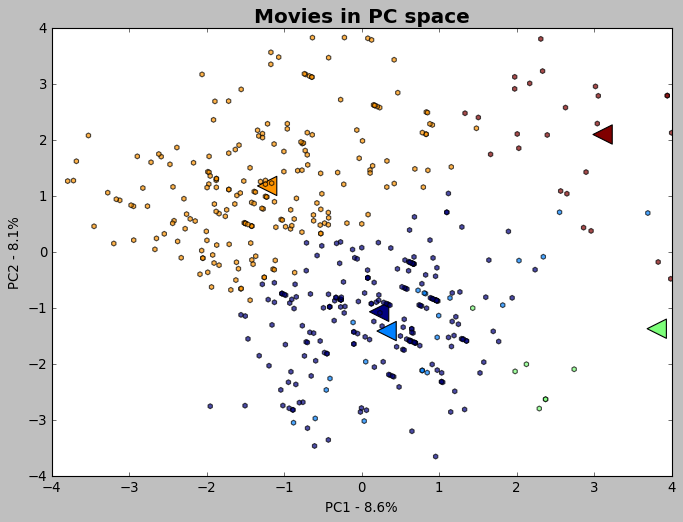

In [8]:
# plot of clusters in PC

# inputs precessing
dum_var_trans = kmeans.transform(dum_var)
pca_center = pca.transform(kmeans.cluster_centers_)
pca_df_C = pd.DataFrame(pca_center, columns=labels) #, , index=  data["movie_title"]
pca_df_sample =  pd.DataFrame(pca_center, columns=labels)
pca_df_sample = pd.DataFrame(pca_data,index=  data["movie_title"], columns=labels) #, , index=  data["movie_title"]
pca_df_sample["cluster"] = kmeans.labels_
pca_df_sample = pca_df_sample.sample(500)


# plot
plt.style.use('classic')
plt.figure(figsize=(10,7))
plt.scatter(pca_df_C.PC1, pca_df_C.PC2, marker = "<", c = [0,1,2,3,4], s = 300)
plt.scatter(pca_df_sample.PC1, pca_df_sample.PC2, marker = "h", c = pca_df_sample["cluster"],alpha = 0.7)
plt.title("Movies in PC space", size = 18, fontweight="bold")
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC2 - {0}%'.format(per_var[1]))
plt.xlim([-4,4])
plt.ylim([-4,4])

plt.show()

Based on the [silhouette parameters](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html), let's explore if we can optimize the numbers of clusters.

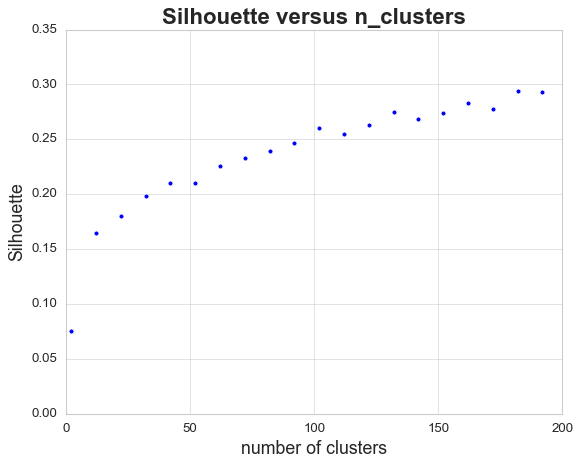

In [9]:
# silhouettes plot
# init = 'k-means++'
from sklearn import cluster, metrics
sns.set_style("whitegrid")

silhouettes = []
for num_clusters in range(2, 200, 10):
    cls = cluster.KMeans(n_clusters= num_clusters, n_init=10, init = "k-means++")
    cls.fit(dum_var)
    silh = metrics.silhouette_score(dum_var, cls.labels_)
    silhouettes.append(silh)
sns.scatterplot(x=range(2,200,10), y=silhouettes, sizes = 30)
plt.title("Silhouette versus n_clusters", fontweight="bold", size = 20)   
plt.xlabel("number of clusters", size = 16)
plt.ylabel("Silhouette", size = 16)
plt.xlim([0,200])
plt.ylim([0,0.35])
plt.show()

We choose n = 99, meaning an average of 50 movies per group.

In [10]:
# k = 99
cls = cluster.KMeans(n_clusters= 99, n_init=10, init = "k-means++"")
cls.fit(dum_var)

SyntaxError: EOL while scanning string literal (<ipython-input-10-8f79e2a56fa6>, line 2)

In [11]:
# prepare "sub" data base
recommender_kmean = data.loc[:,["movie_title","imdb_score","movie_imdb_link"]]
recommender_kmean["cluster"] = cls.labels_

def similar_to_km(df, my_movie_title, n =5):
    '''return top_5 movie similar (Kmean) to my_movie_title, imdb_score is used at the end to order the proposition'''
    
    mask = df["movie_title"] == my_movie_title
    cluster_n = df.loc[mask, "cluster"].values
    mask_c = df["cluster"] == cluster_n[0]
    same_cluster = df[mask_c]
    top_n = same_cluster.sort_values(by = ["imdb_score"], ascending= False)[["movie_title","imdb_score","movie_imdb_link"]].head(n)
    return top_n

In [12]:
recommender_kmean["cluster"].value_counts().tail(10)

162    4
114    4
82     4
186    3
158    3
16     3
176    3
157    2
17     1
151    1
Name: cluster, dtype: int64

One of 99 groups is still with less than 5 occurences (Mulan).

### Tests: Top 5 recommendations with Kmeans (n = 99)

In [13]:
similar_to_km(recommender_kmean,"Monsters, Inc.",n = 5)

,movie_title,imdb_score,movie_imdb_link
43,Toy Story 3,8.3,http://www.imdb.com/title/tt0435761/?ref_=fn_t...
78,Inside Out,8.3,http://www.imdb.com/title/tt2096673/?ref_=fn_t...
1588,Toy Story,8.3,http://www.imdb.com/title/tt0114709/?ref_=fn_t...
93,How to Train Your Dragon,8.2,http://www.imdb.com/title/tt0892769/?ref_=fn_t...
238,"Monsters, Inc.",8.1,http://www.imdb.com/title/tt0198781/?ref_=fn_t...


In [14]:
similar_to_km(recommender_kmean,"Star Wars: Episode VI - Return of the Jedi",n = 5)

,movie_title,imdb_score,movie_imdb_link
3024,Star Wars: Episode IV - A New Hope,8.7,http://www.imdb.com/title/tt0076759/?ref_=fn_t...
1536,Star Wars: Episode VI - Return of the Jedi,8.4,http://www.imdb.com/title/tt0086190/?ref_=fn_t...
3854,Donnie Darko,8.1,http://www.imdb.com/title/tt0246578/?ref_=fn_t...
439,The Hunger Games,7.3,http://www.imdb.com/title/tt1392170/?ref_=fn_t...
1145,Underworld: Evolution,6.8,http://www.imdb.com/title/tt0401855/?ref_=fn_t...


In [15]:
similar_to_km(recommender_kmean,"Scream 3",n = 5)

,movie_title,imdb_score,movie_imdb_link
4638,On the Waterfront,8.2,http://www.imdb.com/title/tt0047296/?ref_=fn_t...
1011,The Life of David Gale,7.5,http://www.imdb.com/title/tt0289992/?ref_=fn_t...
1865,The Constant Gardener,7.5,http://www.imdb.com/title/tt0387131/?ref_=fn_t...
2293,Death Sentence,6.8,http://www.imdb.com/title/tt0804461/?ref_=fn_t...
973,Absolute Power,6.7,http://www.imdb.com/title/tt0118548/?ref_=fn_t...


In [16]:
similar_to_km(recommender_kmean,"Romeo + Juliet",n = 5)

,movie_title,imdb_score,movie_imdb_link
4190,Before Sunrise,8.1,http://www.imdb.com/title/tt0112471/?ref_=fn_t...
4266,Before Sunset,8.0,http://www.imdb.com/title/tt0381681/?ref_=fn_t...
1606,The Notebook,7.9,http://www.imdb.com/title/tt0332280/?ref_=fn_t...
26,Titanic,7.7,http://www.imdb.com/title/tt0120338/?ref_=fn_t...
396,Cast Away,7.7,http://www.imdb.com/title/tt0162222/?ref_=fn_t...


Kmeans seems to work pretty fine. However there are still some weird recommendations: "OldBoy" for "Romeo + Juliette", "On the Waterfront" for "Scream 3"). Maybe reducing the cluster's size might help to solve it.

#  3. NearestNeighbors
This approach seems quite intuitive for this project ([more info on NearestNeighbors](https://scikit-learn.org/stable/modules/neighbors.html#neighbors)). To build the recommendation, we will first select the 30 movies closest to the target, then select the top_5 based on the IMBD score. It offers a more systematique approach than the Kmeans, where the size of the first selection always change (group size).

In [26]:
# Nearest Neighbors

from sklearn.neighbors import NearestNeighbors

# inputs
recommender = data.loc[:,dummy]

# model
nbrs = NearestNeighbors(n_neighbors=30, algorithm= "brute").fit(recommender)

def nearest(my_movie_title, n=5):
    mask = data["movie_title"] == my_movie_title
    target = data.loc[mask,dummy]
    distances, indices = nbrs.kneighbors(target)  # !!! return implicite indices
    expl_idx = data.index[indices[0]]   # index convertion implicite to explicte
    results = data.loc[expl_idx,["movie_title","imdb_score","movie_imdb_link"]]
    results["distance"] = distances[0]   # add distance col
    mask = results["movie_title"] == my_movie_title
    results = results[~mask]   # remove the line with the target (search movie)
    top_n = results.sort_values(by = ["imdb_score"], ascending= (False))[["movie_title","distance","imdb_score","movie_imdb_link"]].head(n)
    return top_n 

### Tests: Top 5 recommendations with NearestNeighbors

In [27]:
nearest("Monsters, Inc.")

,movie_title,distance,imdb_score,movie_imdb_link
78,Inside Out,1.414214,8.3,http://www.imdb.com/title/tt2096673/?ref_=fn_t...
67,Up,1.414214,8.3,http://www.imdb.com/title/tt1049413/?ref_=fn_t...
43,Toy Story 3,1.002952,8.3,http://www.imdb.com/title/tt0435761/?ref_=fn_t...
1588,Toy Story,1.002952,8.3,http://www.imdb.com/title/tt0114709/?ref_=fn_t...
93,How to Train Your Dragon,1.414214,8.2,http://www.imdb.com/title/tt0892769/?ref_=fn_t...


In [28]:
nearest("Star Wars: Episode VI - Return of the Jedi")

,movie_title,distance,imdb_score,movie_imdb_link
2051,Star Wars: Episode V - The Empire Strikes Back,1.000737,8.8,http://www.imdb.com/title/tt0080684/?ref_=fn_t...
3024,Star Wars: Episode IV - A New Hope,0.153800,8.7,http://www.imdb.com/title/tt0076759/?ref_=fn_t...
4690,Destiny,1.002952,8.1,http://www.imdb.com/title/tt2983582/?ref_=fn_t...
0,Avatar,1.026266,7.9,http://www.imdb.com/title/tt0499549/?ref_=fn_t...
2923,Star Trek II: The Wrath of Khan,1.414735,7.7,http://www.imdb.com/title/tt0084726/?ref_=fn_t...


In [29]:
nearest("Scream 3")

,movie_title,distance,imdb_score,movie_imdb_link
2360,Scream,1.414214,7.2,http://www.imdb.com/title/tt0117571/?ref_=fn_t...
4059,Sinister,1.432923,6.8,http://www.imdb.com/title/tt1922777/?ref_=fn_t...
3996,The Witch,1.455948,6.8,http://www.imdb.com/title/tt4263482/?ref_=fn_t...
3697,Saw II,1.018322,6.6,http://www.imdb.com/title/tt0432348/?ref_=fn_t...
3717,Oculus,1.447301,6.5,http://www.imdb.com/title/tt2388715/?ref_=fn_t...


In [31]:
nearest("Romeo + Juliet")

,movie_title,distance,imdb_score,movie_imdb_link
4069,The Apartment,1.0000,8.3,http://www.imdb.com/title/tt0053604/?ref_=fn_t...
4190,Before Sunrise,0.2693,8.1,http://www.imdb.com/title/tt0112471/?ref_=fn_t...
4266,Before Sunset,0.2693,8.0,http://www.imdb.com/title/tt0381681/?ref_=fn_t...
1606,The Notebook,0.0000,7.9,http://www.imdb.com/title/tt0332280/?ref_=fn_t...
26,Titanic,0.1154,7.7,http://www.imdb.com/title/tt0120338/?ref_=fn_t...
